`MonoTools.fit` is the key class needed to implement the fitting of planets with unconstrained periods.

It works by first building a `fit` objects, and telling it the lightcurve, stellar parameters, rvs, etc to use, as well as the planets to model.

It then enables a range of fitting, plotting, and outputs.

In [1]:
from MonoTools import fit
from MonoTools import lightcurve as lc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload 
%autoreload 2

/Users/hosborn/miniconda3/envs/newxo/lib/python3.9/site-packages/theano/configparser.py:255: UserWarning: Theano does not recognise this flag: gcc.cxxflags
  warnings.warn(f"Theano does not recognise this flag: {key}")
Matplotlib created a temporary config/cache directory at /var/folders/p0/tmr0j01x4jb3qrbc5b0gnxcw0000gn/T/matplotlib-zp2wrnxp because the default path (/Users/hosborn/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Using MonoTools.fit for a simulated "Duotransit"

#### Using simulated data 
Let's just put together some fake data where we know the answer and see what we get out! Here's 2 pseuod-sectors of TESS data, and planets at 8d & 35d.

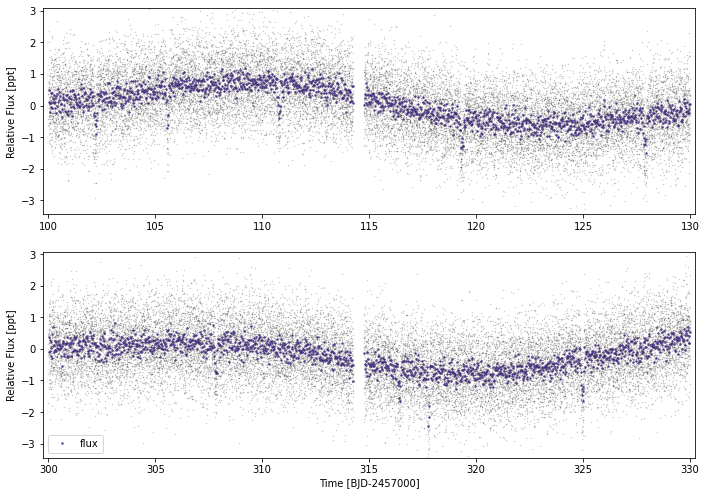

In [2]:
x = np.concatenate((np.arange(100,114.25,2/1440), np.arange(114.75,130,2/1440),
                    np.arange(300,314.25,2/1440), np.arange(314.75,330,2/1440)))

#Adding some randomised sinusoids to mimic stellar variability:
y_sv=abs(np.random.normal(0.0002,0.0005))*np.sin((x+np.random.random()*2*np.pi)/(np.random.normal(8,1)))+abs(np.random.normal(0.0001,0.0005))*np.sin((x+np.random.random()*2*np.pi)/(np.random.normal(3,0.8)))

#Now adding noise to the lightcurve
noise=0.0008
y = np.random.normal(1.0,noise,len(x))+y_sv
yerr = noise*1.1+np.zeros_like(y)

it0s=np.array([np.random.random()*8.56781,105.57])

#Depth here is a little over double the per-point scatter
idepths=np.array([0.0007,0.0018])
import exoplanet as xo
true_orbit = xo.orbits.KeplerianOrbit(period=np.array([8.56781,35.36789]),
                                      t0=it0s, b=np.random.random(2), 
                                      omega=np.random.random(2)*2*np.pi, ecc=np.random.random(2)*0.05)
true_model = np.sum(xo.LimbDarkLightCurve([0.3, 0.2]).get_light_curve(orbit=true_orbit, t=x, r=np.sqrt(idepths)).eval(),axis=1)
y += true_model

lc1=lc.lc();lc1.load_lc(time=x[:21240], fluxes=y[:21240], flux_errs=yerr[:21240],
                        flx_system='norm1',jd_base=2457000,mission='tess',sect='98',src='test')
lc2=lc.lc();lc2.load_lc(time=x[21240:], fluxes=y[21240:], flux_errs=yerr[21240:],
                        flx_system='norm1',jd_base=2457000,mission='tess',sect='99',src='test')
ilc=lc.multilc(123456789,'tess',do_search=False,load=False)
ilc.stack([lc1,lc2])

#plotting the data:
ilc.plot(plot_rows=2)

### Initialising a `fit` object

First thing to do is to intialise the `fit` object. This requires `id` and `mission` arguments. 

These help point `MonoTools` where to save/access data. `MonoTools` will access the `$MONOTOOLSDATA` system environment variable for custom data locations, but will default to store data in `MonoTools/data` where the module is stored. For each `id`/`mission` pair, `MonoTools` will create a fresh directory to store all data with the form `[KIC/TIC/EPIC][zero-padded 11-digit ID], i.e. `MonoTools/data/TIC00100990000`.

In [3]:
mod = fit.monoModel(123456789,'tess',lc=ilc)

## Adding stellar parameters

We need to makesure our star is defined. A good stellar density can especially help constrain the periods of planets on unconstrained orbits.

By default, these are taken from the data within a `MonoTools.lightcurve.multilc` object (i.e. from the TIC), but if we do not have that, as here, we need to initialise the stellar parameters directly.

Using `init_starpars` we must include a `Rstar` and `Teff` input, and then one or two of `logg`, `rhostar` or `Mstar` (if not, the other one or two of these parameters are calculated from the known params):

In [4]:
mod.init_starpars(Rstar=[0.98,0.05,0.05],
                  rhostar=[1.02,0.1,0.1],
                  Teff=[5660,120,120])

## Adding planets to the model:

To initialise the planets to fit, we have a couple of options. Either we run one of the three planet types directly, namely `add_multi` (multi-transiting planet with a contrained period), `add_duo` (duo-transiting planet with two transits), and `add_mono` (single-transiting candidate). There is also `add_rvplanet` for an RV-only Keplerian signal.

In this case, we add the `duo` by specifying the transit times of each transit, the depth, and a duration in a dictionary, as well as our name for the planet like so:

In [5]:
mod.add_duo({'tcen':105.57,'tcen_2':317.78,'tdur':0.275,'depth':idepths[1]},'c')

Or we can use the `add_planet` function which wraps all four of these options (so long as we specify in the function which type we want).

For multi-transiting planets, we also need to specify a period (obviously) and a period error (not so obviously) which helps loosely constrain the fitting priors.

In [6]:
mod.add_planet('multi',{'tcen':it0s[0],'period':8.567,'period_err':0.005,'tdur':0.12,'depth':idepths[0]},'b')

##### Accessing planet data

The initial planetary data is stored as dictionaries in `mod.planets`:

In [ ]:
mod.planets

## Performing an initial model fit

Now we have the planets we want to model, let's initialise the model itself and obtain a best-fit we can inspect.

We do that using `init_model()`.

These are the key arguments to be aware of:
* `use_GP`: Whether to fit a GP in parrallel to the transit fit. If yes (and `train_GP`=True) we train a SHO celerite2 kernel on out-of-transit data and then co-fit with the data. If not, we perform spline fitting to out-of-transit data and flatten the lightcurve.
* `bin_oot`: Whether to bin the out-of-transit points. This reduces compute time. Default = True
* `cut_distance`: How far from each transit (in durations) to either "cut" or "bin".
* `interpolate_v_prior`: Whether to fit only for the transit shape parameters and use interpolation to map this to orbital period. Default: True
* `ecc_prior`: Which eccentricity prior to use for the interpolation ('uniform', 'kipping', 'vaneylen', or the default 'auto', which chooses between kipping & vaneylen based on multiplicity).

In [7]:
mod.init_model()
#This can be reasonably slow, as we have to:
#   1) train the GP and then 2) progressively minimize more and more parameters in the combined model

initialising and training the GP
4.1887902047863905 96.40483785469252 0.6283185307179586 {'alpha': 6.570746817359475, 'beta': 8.763441085702263} 1.157539843441598
0.36916761081013877 0.36916761081013877 0.7525577544224005


optimizing logp for variables: [phot_mean, phot_w0, phot_power, logs2]


message: Optimization terminated successfully.
logp: -52.09461968896364 -> -0.77344119054942


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phot_power, phot_w0, logs2, phot_mean]


Sampling 2 chains for 594 tune and 900 draw iterations (1_188 + 1_800 draws total) took 22 seconds.


ts
ts


optimizing logp for variables: [b_b, logror_b, tdur_c, b_c, logror_c]


message: Desired error not necessarily achieved due to precision loss.
logp: -9256.560591192092 -> -8886.45446053474
optimizing logp for variables: [per_b, logror_b, t0_2_c, logror_c]


message: Desired error not necessarily achieved due to precision loss.
logp: -8886.45446053474 -> -8840.288083568093
optimizing logp for variables: [omega_b, ecc_b, b_b, logror_b, t0_b, tdur_c, b_c, logror_c, t0_c, logrho_S]


message: Desired error not necessarily achieved due to precision loss.
logp: -8840.288083568095 -> -8806.525492397373
optimizing logp for variables: [phot_mean, phot_w0, phot_power, logs2]


message: Desired error not necessarily achieved due to precision loss.
logp: -8806.525492397372 -> -8795.922317173929
optimizing logp for variables: [per_b, b_b, logror_b, tdur_c, b_c, logror_c]


message: Desired error not necessarily achieved due to precision loss.
logp: -8795.922317173929 -> -8795.222765315853
optimizing logp for variables: [u_star_tess, logrho_S, Rs, logs2, phot_mean, phot_w0, phot_power, omega_b, ecc_b, b_b, logror_b, t0_b, tdur_c, b_c, logror_c, t0_c]


message: Desired error not necessarily achieved due to precision loss.
logp: -8795.222765315853 -> -8794.684330132783
optimizing logp for variables: [phot_mean, phot_power, phot_w0, logs2, u_star_tess, b_b, omega_b, ecc_b_frac, ecc_b_sigma_rayleigh, ecc_b_sigma_gauss, ecc_b, logror_b, per_b, t0_b, tdur_c, b_c, logror_c, t0_2_c, t0_c, Rs, logrho_S]


message: Desired error not necessarily achieved due to precision loss.
logp: -8794.684330132783 -> -8792.273722947479


## Plotting the initial model

We can now plot the initial minimized model. This plots both the lightcurves and a zoom at the phase-folded transits

initialising transit
Initalising Transit models for plotting with n_samp= 10
Initalising GP models for plotting with n_samp= 1
successfully interpolated GP means


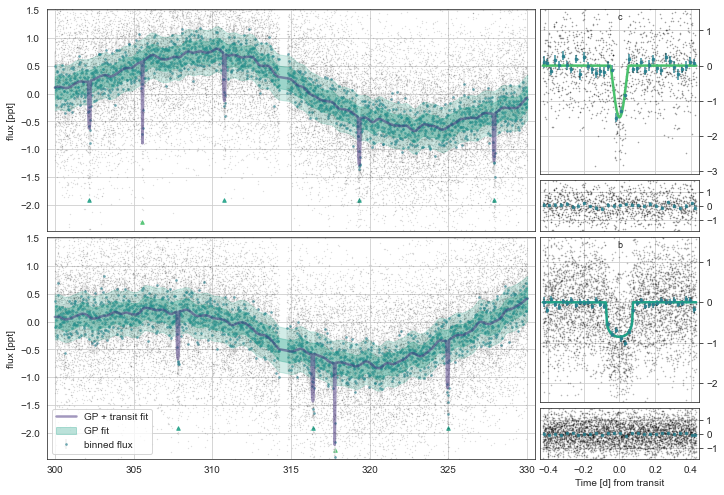

In [8]:
mod.Plot(n_samp=1)

## Sampling with PyMC

This uses the `exoplanet`/`PyMC3` `NUTS` sampler under the hood, which should provide chains with far higher effective samples compared to MCMC, and the `PyMC3_ext` implementation allows for correlations to be trained/learned.

Some important arguments:
* `n_draws` - number of samples to take per chain
* `n_burn_in` - number of samples which will constitute the "burn-in" (in the default case, this is 2/3 `n_draws`)
* `overwrite` - whether to start fresh or load a saved model
* `continue_sampling` - whether to start from the MCMC trace already saved within the model
* `chains` - number of chains to sample (defaults to 4)

In [9]:
mod.SampleModel(n_draws=1333)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phot_mean, phot_power, phot_w0, logs2, u_star_tess, b_b, omega_b, ecc_b_frac, ecc_b_sigma_rayleigh, ecc_b_sigma_gauss, ecc_b, logror_b, per_b, t0_b, tdur_c, b_c, logror_c, t0_2_c, t0_c, Rs, logrho_S]


Sampling 4 chains for 879 tune and 1_333 draw iterations (3_516 + 5_332 draws total) took 3272 seconds.


Saving sampled model parameters to file with shape:  (127, 14)


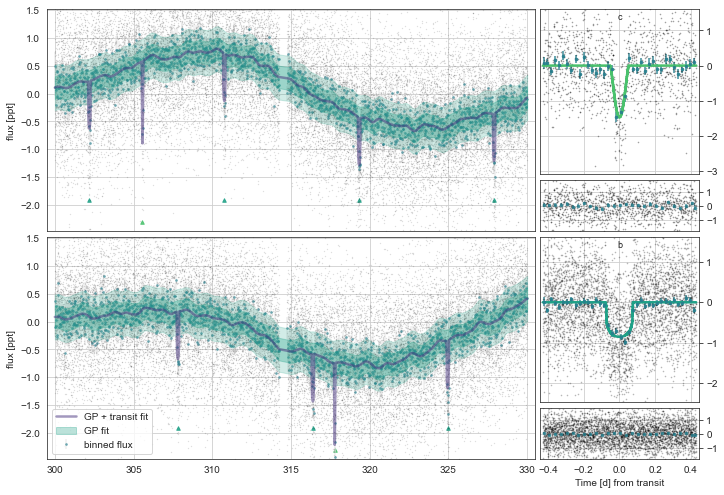

In [10]:
mod.Plot(n_samp=101)

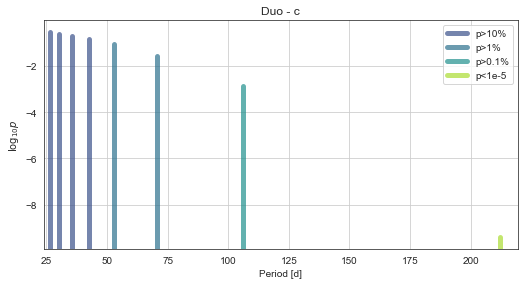

In [11]:
mod.PlotPeriods()

In [12]:
df=mod.MakeTable()
df

Saving sampled model parameters to file with shape:  (127, 14)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,5%,-$1\sigma$,median,+$1\sigma$,95%
Rs[0],1.00002,0.05018,0.90178,1.09296,0.00073,0.00052,4762.06164,3486.56172,1.00048,0.91665,0.95029,1.00004,1.04953,1.08244
per_b,8.56762,0.00013,8.56738,8.56785,0.00000,0.00000,4117.37595,3287.41837,1.00041,8.56741,8.56750,8.56762,8.56774,8.56781
logs2[0],-4.61820,0.11593,-4.86032,-4.42118,0.00175,0.00124,4552.05885,3293.66915,1.00017,-4.82146,-4.73309,-4.61235,-4.50312,-4.43814
rho_S,0.99957,0.09460,0.82539,1.17588,0.00181,0.00128,2706.92618,2759.04023,1.00152,0.84542,0.90274,0.99826,1.09282,1.15521
Ms[0],1.00755,0.18183,0.69458,1.36310,0.00296,0.00209,3769.78214,3726.01701,1.00028,0.73662,0.82663,0.99425,1.18580,1.32635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
logprob_c[7],-1.98908,15.90281,-10.37283,2.12143,0.42148,0.29809,453.08112,1012.71069,1.01755,-11.60142,-4.85724,0.87274,1.80287,2.07808
ecc_c,0.54311,0.06803,0.40762,0.65214,0.00373,0.00264,397.40728,804.58241,1.01610,0.41178,0.47088,0.55303,0.61213,0.63628
ecc_marg_c,0.54311,0.06803,0.40762,0.65214,0.00373,0.00264,397.40728,804.58241,1.01610,0.41178,0.47088,0.55303,0.61213,0.63628
vel_marg_c,1.00109,0.03196,0.96338,1.06398,0.00108,0.00077,784.04144,2315.61306,1.00950,0.97163,0.97712,0.98574,1.03774,1.06505


The "true" period is one of the highest-probability. And the "marginalised period" for the planet (i.e. an average of all period aliases weighted by their respective probabilities) is close to the true value!

# Using MonoTools.fit on real "Duotransits"

Let's try MonoTools out with some real data. Let's use TOI-2076, which has *two* Duo-transiting planets (see [Hedges et al 2021](https://arxiv.org/abs/2111.01311) and [Osborn et al. 2022](https://arxiv.org/abs/TBD)).

Here, unless we specify otherwise, the monoModel will load a TESS lightcurve (as a `MonoTools.lightcurve.multilc` object), as well as stellar parameters from the TIC.

In [2]:
mod = fit.monoModel(27491137,'tess')

Getting all IDs
Empty TableList


### Checking the lightcurve
Using the lc.plot() feature.

Here we can see that SPOC really fails in the PDC detrended flux for the second sector. Let's just use the raw flux there instead

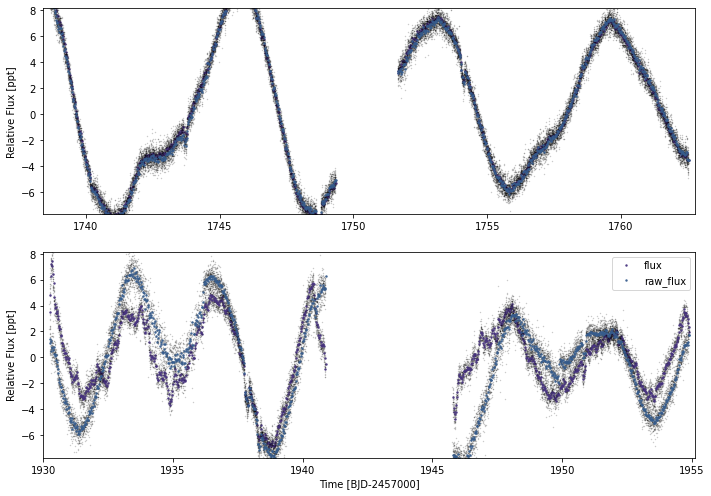

In [3]:
mod.lc.plot(timeseries=['flux','raw_flux'])

In [4]:
mod.lc.flux[mod.lc.cadence=='ts_120_pdc_23']=mod.lc.raw_flux[mod.lc.cadence=='ts_120_pdc_23']
#Need to re-bin
mod.lc.bin()

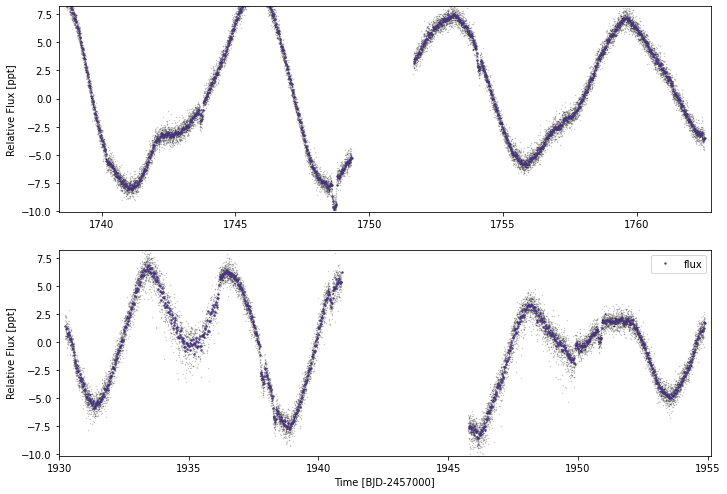

In [5]:
mod.lc.plot()

That looks better. Although there is still some excess scatter on the second sector.

### Adding the planets to the model:

In [6]:
mod.add_multi({'tcen':1743.7199,'period':10.356192390280784,'period_err':0.0025,
                   'tdur':3.25/24,'depth':1.4e-3},'b')
mod.add_planet('duo',{'tcen':1748.675688904365,'tcen_2':1937.821199104365,
                      'tdur':4.186/24,'depth':2.0e-3},'c')
mod.add_duo({'tcen':1762.6651396199247,'tcen_2':1938.2899096646295,
                 'tdur':3.046/24,'depth':1.4e-3},'d')

### Initialising a less computationally intensive model

By default, the model bins the out-of-transit lightcurve and performs a GP fit on all of the data. But we can manipulate how MonoTools performs the fit.

Here let's turn off the GP and only use a zoomed-in view of a detrended/flattened lightcurve for each of the transits using `bin_oot = False` and `cut_distance=3.5`. This should also be quicker. We specify a "knot distance" `knot_dist` of 0.6 for the spline as this is a very wiggly lightcurve!

In [8]:
mod.init_model(use_GP=False,
               bin_oot=False,
               cut_distance=3.5, 
               knot_dist=0.6)

yerr __str__ = [0.63242328 0.63232464 0.63244091 ... 0.6402334  0.64008134 0.64026565]


Let's plot the initial model:

initialising transit
Initalising Transit models for plotting with n_samp= 10


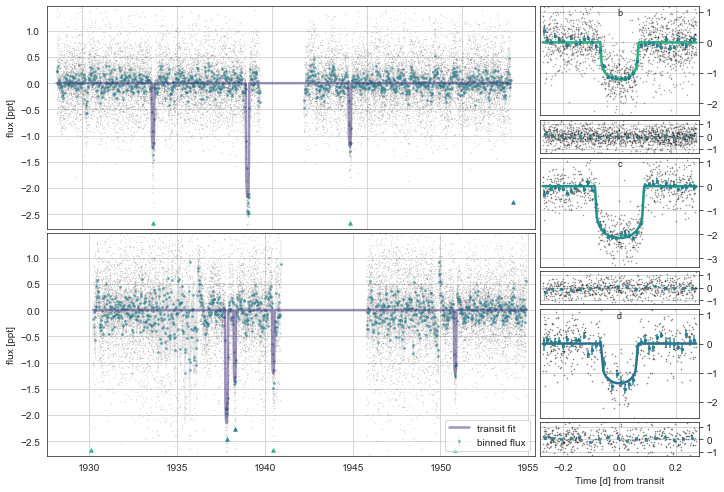

In [9]:
mod.Plot(plot_flat=True,overwrite=True) 
#(If there are previous models initialised, it's important to use overwrite here)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phot_mean, logs2, u_star_tess, tdur_d, b_d, logror_d, t0_2_d, t0_d, tdur_c, b_c, logror_c, t0_2_c, t0_c, b_b, omega_b, ecc_b_frac, ecc_b_sigma_rayleigh, ecc_b_sigma_gauss, ecc_b, logror_b, per_b, t0_b, Rs, logrho_S]


Sampling 4 chains for 879 tune and 1_333 draw iterations (3_516 + 5_332 draws total) took 2207 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Saving sampled model parameters to file with shape:  (246, 14)


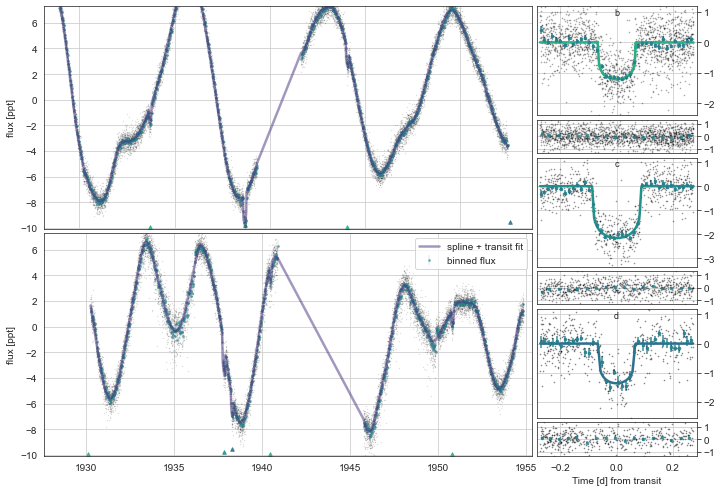

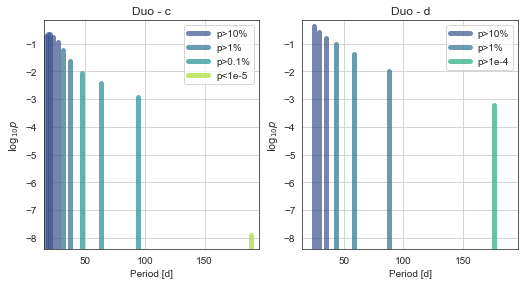

In [11]:
mod.SampleModel(n_draws=1333)
mod.Plot(n_samp=101)
mod.PlotPeriods()

## Predicting future transits

When we have many possible aliases, we really want future photometry to be able to confirm them.
You can generate a table of upcoming transits in `MonoTools.fit` using `mod.PredictFutureTransits()`.

Here we ask for 50 days starting on March 7th (using astropy.Time)

In [14]:
from astropy.time import Time
upcoming_trans = mod.PredictFutureTransits(time_start=Time('2022-03-07T00:00:00', format='isot', scale='utc'),
                                           time_dur=50)
upcoming_trans

time range 2022-03-07T00:00:00.000 -> 2022-04-25T19:49:50.292


,transit_mid_date,transit_mid_med,transit_dur_med,transit_dur_-1sig,transit_dur_+1sig,transit_start_+2sig,transit_start_+1sig,transit_start_med,transit_start_-1sig,transit_start_-2sig,...,transit_fractions,log_prob,prob,planet_name,alias_n,alias_p,aliases_ns,aliases_ps,total_prob,num_aliases
0,2022-03-08T13:25:28.308,2647.059355,0.176546,0.174889,0.178425,2646.983548,2646.977201,2646.971082,2646.964549,2646.957561,...,19/4,-16.192243,9.285353e-08,duo_c,3,47.282428,"3,7","47.2824,23.6412",0.205571,2.0
1,2022-03-13T19:30:39.727,2652.312960,0.176546,0.174889,0.178425,2652.237219,2652.230838,2652.224687,2652.218118,2652.211088,...,43/9,-1.329252,2.646753e-01,duo_c,8,21.014413,8,21.0144,0.264675,1.0
2,2022-03-16T12:35:24.796,2655.024593,0.136204,0.134537,0.138170,2654.971464,2654.963541,2654.956490,2654.949625,2654.942411,...,88,0.000000,1.000000e+00,multi_b,0,10.355724,0,10.3557,1.000000,1.0
3,2022-03-18T00:22:48.826,2656.515843,0.176546,0.174889,0.178425,2656.440156,2656.433747,2656.427570,2656.420972,2656.413910,...,24/5,-9.125435,1.088614e-04,duo_c,4,37.825943,"4,9","37.8259,18.913",0.275734,2.0
4,2022-03-21T10:54:34.346,2659.954564,0.176546,0.174889,0.178425,2659.878922,2659.872493,2659.866291,2659.859671,2659.852582,...,53/11,-1.838018,1.591326e-01,duo_c,10,17.193610,10,17.1936,0.159133,1.0
5,2022-03-24T07:41:02.392,2662.820167,0.176546,0.174889,0.178425,2662.744561,2662.738116,2662.731893,2662.725251,2662.718142,...,29/6,-4.859221,7.756525e-03,duo_c,5,31.521619,5,31.5216,0.007757,1.0
6,2022-03-26T21:07:40.023,2665.380324,0.136204,0.134537,0.138170,2665.327362,2665.319342,2665.312222,2665.305277,2665.297971,...,89,0.000000,1.000000e+00,multi_b,0,10.355724,0,10.3557,1.000000,1.0
7,2022-03-27T09:09:18.068,2665.881459,0.133908,0.129489,0.137680,2666.022889,2665.922736,2665.814505,2665.708043,2665.610466,...,36/7,-0.559529,5.714780e-01,duo_d,6,25.089347,6,25.0893,0.571478,1.0
8,2022-03-28T19:45:29.154,2667.323254,0.176546,0.174889,0.178425,2667.247708,2667.241236,2667.234981,2667.228306,2667.221165,...,34/7,-2.440342,8.713102e-02,duo_c,6,27.018530,6,27.0185,0.087131,1.0
9,2022-03-31T13:30:45.125,2670.063022,0.133908,0.129489,0.137680,2670.205592,2670.104908,2669.996068,2669.889008,2669.790883,...,31/6,-1.138605,3.202655e-01,duo_d,5,29.270905,5,29.2709,0.320265,1.0


## Creating Cheops XML files

If you want to directly export the predicted aliases to Cheops input XML files, with `MonoTools` you can with `mod.MakeCheopsOR()`. It's necessary to specify which planet to generate

The Gaia DR2 ID must be specified, though if the lightcurve was loaded with `lightcurve.multilc`, then it's pre-loaded from the TIC.

This has many things to tune, but the default produces at least 1 orbit on either side of the predicted transit (`oot_min_orbits=1.0`), covers the 3-sigma timing window (`timing_sigma=3`), includes a further 1.4 orbits of "flexibility" to assist in scheduling (`orbits_flex=1.4`), observes with minimum efficiency greater than 45% (`min_eff=45`), and will observe between 4 and 14 orbits (`min_orbits=4.0`,`max_orbits=14`).

In terms of which aliases, to schedule, `MakeCheopsOR()` produces ORs for the highest-probability aliases which together make up the 2-sigma period posterior (`observe_sigma=2`), observing the top-25% of these in priority 1 (`prio_1_threshold=0.25`), 0% in priority 3 (prio_3_threshold=0.0,) and the rest in priority 2 (i.e. 75%).

`pycheops` is necessary to finish the set-up of ORs using `make_xml_files`.

In [16]:
c_cheops_ORs=mod.MakeCheopsOR(pl='c',observe_sigma=1.5,outfilesuffix='_example.csv')
c_cheops_ORs

INFO: Query finished. [astroquery.utils.tap.core]
time range 2022-01-27T14:03:42.476 -> 2022-07-26T14:03:42.476
Run the following command in a terminal to generate ORs:
"make_xml_files /Volumes/LUVOIR/MonoToolsData/TIC00027491137/TIC00027491137_2022-03-06_8_example.csv --auto-expose -f"


,BJD_0,BJD_early,BJD_late,Gaia_DR2,Gmag,MinEffDur,N_Ranges,N_Visits,ObsReqName,Old_T_eff,...,Priority,Programme_ID,SpTy,T_visit,Target,Vmag,_DEJ2000,_RAJ2000,e_Gmag,e_Vmag
7,2.458938e+06,2.459607e+06,2.459787e+06,1490845584382687232,8.910282,45,0,1,TIC27491137_c_period23;64_prob0.20,-99.0,...,2,0048,K1,35402,TIC27491137,9.121931,39:47:25.545,14:29:34.2428,0.000479,0.046337
8,2.458938e+06,2.459607e+06,2.459787e+06,1490845584382687232,8.910282,45,0,1,TIC27491137_c_period21;01_prob0.26,-99.0,...,2,0048,K1,35402,TIC27491137,9.121931,39:47:25.545,14:29:34.2428,0.000479,0.046337
9,2.458938e+06,2.459607e+06,2.459787e+06,1490845584382687232,8.910282,45,0,1,TIC27491137_c_period18;91_prob0.27,-99.0,...,2,0048,K1,35402,TIC27491137,9.121931,39:47:25.545,14:29:34.2428,0.000479,0.046337


# Using MonoTools.fit on a real Duotransit with RVs

We can also use radial velocities to instruct our Duotransit fits.

Let's use the TOI-561 system as an example, for which the RVs were published in Lacedelli 2022.

Unfortunately, the way it is currently implemented, including RVs in `MonoTools.fit` only works with a single duo or monotransiting planet... So we will assume the 24d planet is solved (at is was with e.g. Cheops) and only the outer planet has an undetermined period.

To include the RVs, we need to call the `add_rvs` function with a dictionary loaded with array of `time`, `rv`, `rv_err`, plus extra info on the `rv_unit` (kms or ms), the time zero point `jd_base`, and potentially a telescope index array (with strings associating each RV with each telescope).

In [2]:
toi561 = fit.monoModel(377064495,'tess')

Getting all IDs
Empty TableList


Let's plot the true ephemeridis:

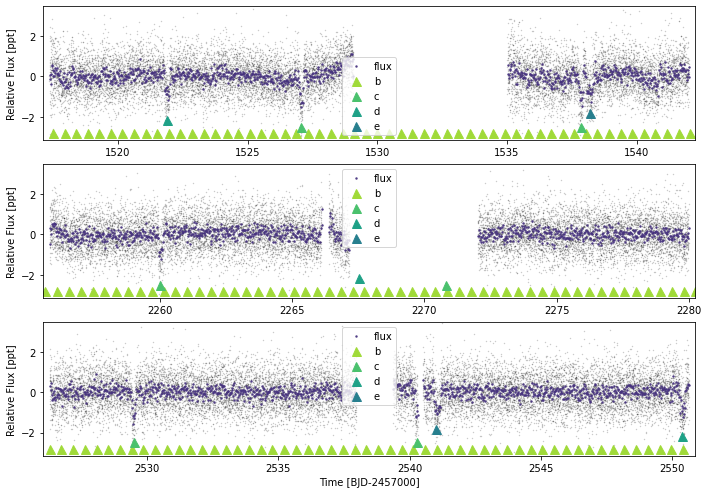

In [3]:
toi561.lc.plot(plot_ephem={'b':{'p':0.4465688,'period_err':0.000001,'t0':2317.7498,'tdur':1.31/24,'depth':0.0155**0.5},
                           'c':{'p':10.778831,'period_err':0.000036,'t0':2238.4629,'tdur':3.75/24,'depth':0.0316**0.5},
                           'd':{'p':25.7124,'period_err':0.0001,'t0':2318.966,'tdur':4.54/24,'depth':0.0306**0.5},
                           'e':{'p':77.14,'period_err':0.25,'t0':1538.180,'tdur':6.98/24,'depth':0.0278**0.5}})

In [4]:
from MonoTools import tools
from astropy.io import ascii
init_rv_tab=ascii.read(tools.MonoData_tablepath+'/TOI561_table2.dat').to_pandas()
rvtab={'time':init_rv_tab['BJD_TDB'].values-2457000,
       'rv':init_rv_tab['RV'].values,
       'rv_err':init_rv_tab['err_RV'].values,
       'rv_unit':'m/s'}

#### Including the RVs and stellar parameters from Lacedelli et al

using `add_rvs` and `init_starpars`.

We can specify the degree of polynomial trend we want to include in the RV fitting using `n_poly_trend` (default is 2).

In [5]:
toi561.add_rvs(rvtab,n_poly_trend=2)

Assuming RV unit is in m/s
Assuming all one telescope (HARPS).


In [6]:
toi561.init_starpars(Rstar=[0.843,0.005,0.005],
                     logg=[4.5,0.12,0.12],
                     Mstar=[0.806,0.12,0.036],
                     Teff=[5372,70,70])

#### Initialising the four planets and model:

In [7]:
toi561.add_planet('multi',{'period':0.4465688,'period_err':0.000001,'tcen':2317.7498,'tdur':1.31/24,'depth':0.0155**2,'K':1.56},'b')
toi561.add_planet('multi',{'period':10.778831,'period_err':0.000036,'tcen':2238.4629,'tdur':3.75/24,'depth':0.0316**2,'K':1.84},'c')
toi561.add_planet('multi',{'period':25.7124,'period_err':0.0001,'tcen':2318.966,'tdur':4.54/24,'depth':0.0306**2,'K':3.1},'d')
toi561.add_planet('duo',{'tcen':1538.180,'tcen_2':2541.08,'tdur':6.98/24,'depth':0.0278**2},'e')


In [10]:
toi561.init_model(use_GP=False,
                  bin_oot=False,
                  cut_distance=1.75)

rv_offsets __str__ = [79699.73]
logK __str__ = 0.44468582126144574
logK __str__ = 0.6097655716208943
logK __str__ = 1.1314021114911006
min_eccs[pl] __str__ = [0.70507819 0.56915964 0.47082042 0.39290426 0.32823486 0.27297434
 0.22478612 0.18212606 0.14391373 0.1093605  0.07787159 0.04898653
 0.02234115 0.00235778 0.04683396 0.06697604 0.12065873 0.13665255
 0.15183626 0.18003928 0.20572586 0.21774181 0.22925865 0.26114276
 0.28045379 0.29842345 0.31520244 0.36623555]
omegas[pl] __str__ = [1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 4.71238898 4.71238898 4.71238898 4.71238898 4.71238898
 4.71238898 4.71238898 4.71238898 4.71238898 4.71238898 4.71238898
 4.71238898 4.71238898 4.71238898 4.71238898]
bs[pl] __str__ = 0.1
t0s[pl] __str__ = 2541.08
pers[pl] __str__ = [1002.9         501.45        334.3         250.725       200.58
  167.15        143.27142857  125.3625      111.43333333  100.

#### Plotting the photometric and RV models:

initialising transit
Initalising Transit models for plotting with n_samp= 10


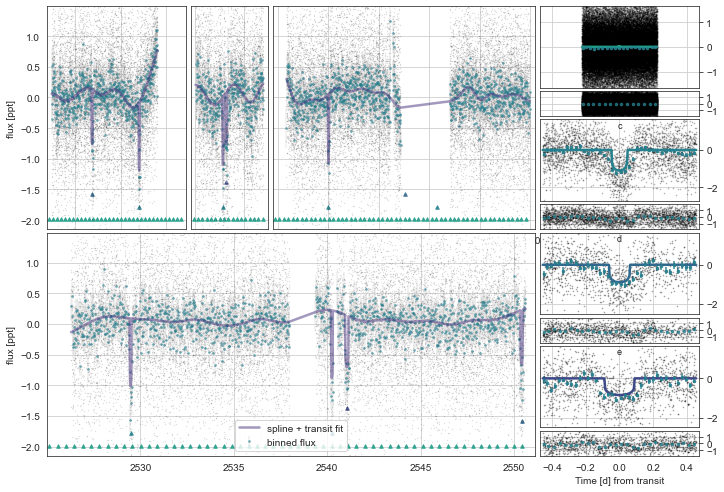

In [11]:
toi561.Plot()

Here, the RVs plot the timeseries on the left and the phase-folds on the right.

The upper three RV vurves correspond to the multi-transiting planets, while the lower four phase-folded RV curves with dashed lines correspond to the best-fitting period aliases from the model.

Similarly, the dashed lines on the right show the best-fit RV models for the best period aliases, though the transparency of these are weighted by probability, and in this case only the 77.1d alias appears present (as it shows by far the strongest RV signal).

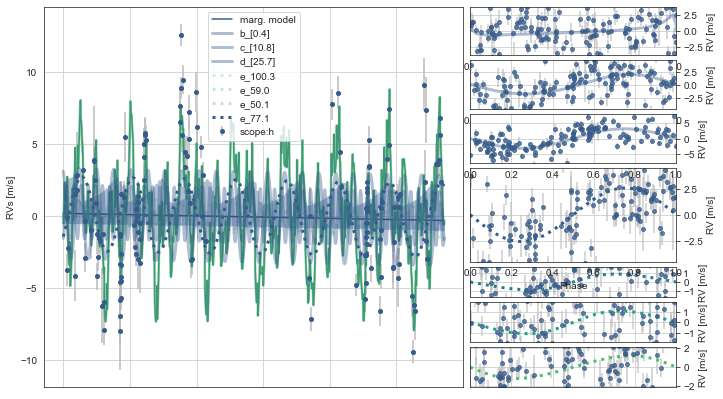

In [12]:
toi561.PlotRVs()

#### Sampling the TOI-561 model

This is a big model so we haven't included enough samples here for a reasonable result yet, but this should be demonstrative.

In [13]:
toi561.SampleModel(n_samp=250)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phot_mean, rv_logs2, rv_polys, rv_offsets, logs2, u_star_tess, tdur_e, b_e, logror_e, t0_2_e, t0_e, logK_d, b_d, omega_d, ecc_d_frac, ecc_d_sigma_rayleigh, ecc_d_sigma_gauss, ecc_d, logror_d, per_d, t0_d, logK_c, b_c, omega_c, ecc_c_frac, ecc_c_sigma_rayleigh, ecc_c_sigma_gauss, ecc_c, logror_c, per_c, t0_c, logK_b, b_b, omega_b, ecc_b_frac, ecc_b_sigma_rayleigh, ecc_b_sigma_gauss, ecc_b, logror_b, per_b, t0_b, Rs, logrho_S]


Sampling 4 chains for 330 tune and 500 draw iterations (1_320 + 2_000 draws total) took 687 seconds.
The acceptance probability does not match the target. It is 0.9666844230354691, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9742654142610762, but should be close to 0.9. Try to increase the number of tuning steps.


Saving sampled model parameters to file with shape:  (536, 14)


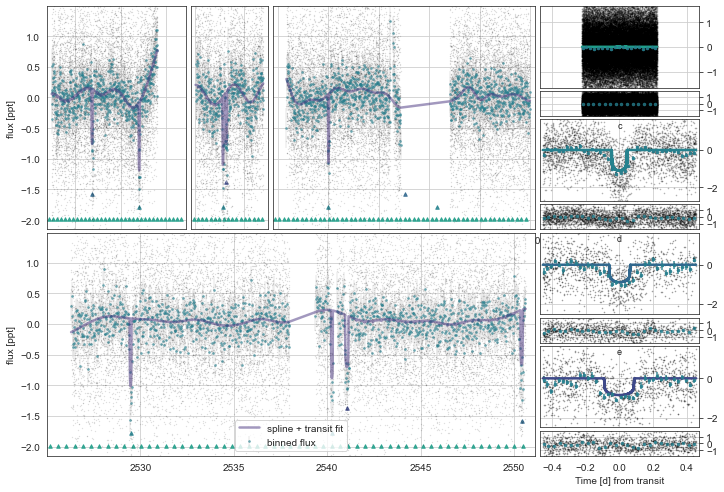

In [14]:
toi561.Plot()

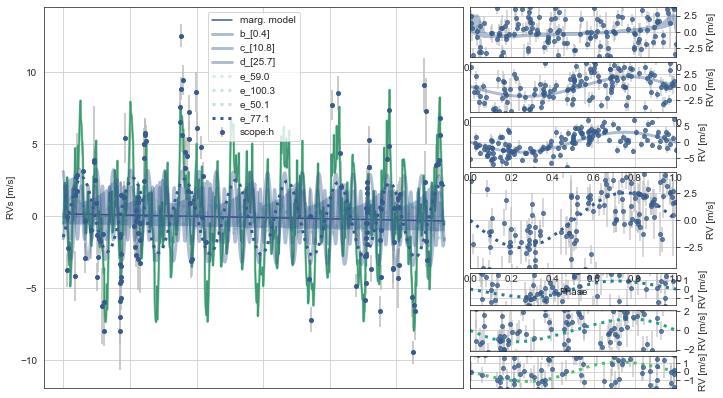

In [15]:
toi561.PlotRVs()

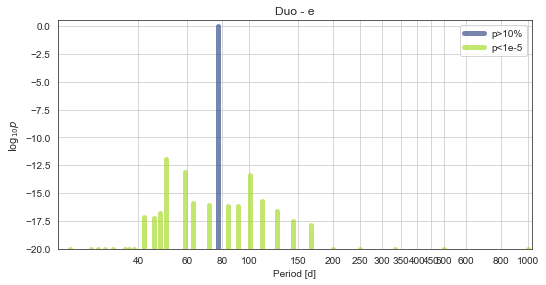

In [17]:
toi561.PlotPeriods(xlog=True,ymin=-20)

Here we can see that the model with photometry + RVs clearly found the 77d period, with a preference of $\sim1\times10^{12}$ over the next-closest RV aliases.